<a href="https://colab.research.google.com/github/gkant06/BMS_Capstone/blob/main/feature_extraction/rvae_afm_AtomAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/pycroscopy/atomai # install the latest version from source

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pycroscopy/atomai to /tmp/pip-req-build-u_zu2fko
  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/atomai /tmp/pip-req-build-u_zu2fko
  Resolved https://github.com/pycroscopy/atomai to commit 6d187296074143d017ca8fc60302364cd946b180
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 8.5 MB/s eta 0:00:00
  Created wheel for atomai: filename=atomai-0.7.8-py3-none-any.whl size=162558 sha256=7b0191fa2c999d9da8652d8aa7c2da60999f5341f486f17edf905929b24de7e8
  Stored in directory: /tmp/pip-ephem-wheel-cac

In [2]:
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import cv2
import atomai as aoi

import torch
import torch.nn as nn
import torch.fft
from torch import tensor as tt
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from PIL import Image
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import os
import atomai as aoi
from typing import Optional, Tuple, Type, Union
from typing import Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from torch import tensor as tt
import torchvision.transforms.functional as F
from scipy.stats import norm
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import pandas as pd
from torchvision.transforms import ToTensor

import warnings
warnings.filterwarnings("ignore", module="torchvision.datasets")

In [4]:
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

In [5]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Capstone-BMS

Mounted at /content/drive
/content/drive/MyDrive/Capstone-BMS


In [6]:
def load_training_set(path):
    data = []
    img_path = []
    print(len(os.listdir(dir_path)))

    for f in os.listdir(dir_path):
        image_path = os.path.join(dir_path, f)
        image = cv2.imread(image_path)
        resized_img = cv2.resize(image, (32, 32))
        resized_img = resized_img.astype(np.uint8)
        image = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB) # Convert image to RGB
        #plt.imshow(image)
        data.append(image)
        img_path.append(f)
    
    # Convert the data list to a torch tensor
    data = np.array(data)
    data = data.astype('float32')

    # Reshape 
    img_width  = 32 #data.shape[1]
    img_height = 32 #data.shape[2]
    num_channels = 3 #RGB scale --> 3 channel
    data = data.reshape(data.shape[0], img_height, img_width, num_channels)
    print(data.shape)
    imstack_train_r = torch.zeros(data.shape, dtype=torch.float32)
    # labels, angles = [], []
    for i in range(data.shape[0]):
        #theta = torch.randint(*rotation_range, (1,)).float()
        #im = im.rotate(theta.item(), resample=Image.BICUBIC)
        im = data[i,:,:,:]
        #print(im.shape)
        im_tensor = torch.tensor(np.array(im))  # Convert to tensor and normalize
        #imstack_train_r[i] = im_tensor.unsqueeze(0)
        imstack_train_r[i] = ToTensor()(im).permute(1, 2, 0)
        #labels.append(lbl)
        #angles.append(torch.deg2rad(theta))
    imstack_train_r /= 255 #imstack_train_r.max()
    return imstack_train_r, img_path#

def init_dataloader(*args: torch.Tensor, **kwargs: int) -> Type[torch.utils.data.DataLoader]:

    batch_size = kwargs.get("batch_size", 100)
    tensor_set = torch.utils.data.dataset.TensorDataset(*args)
    data_loader = torch.utils.data.DataLoader(
        dataset=tensor_set, batch_size=batch_size, shuffle=True)
    return data_loader

In [7]:
#dir_path = 'ASO_good_droplet'
#dir_path = 'ASO_good_misclassified'
#dir_path = 'output_images_mAb1_20007'
#dir_path = 'afm_sample'
dir_path = 'AFM IMAGES FINAL/output_images'
train_data, data_path = load_training_set(dir_path) 
train_loader = init_dataloader(train_data, batch_size=32)

2786
(2786, 32, 32, 3)


In [8]:
# Ititialize model
in_dim = (32, 32, 3)

vae = aoi.models.VAE(in_dim)
#rvae = aoi.models.rVAE(in_dim)

# Train
vae.fit(X_train=train_data, X_test=train_data, training_cycles=40, batch_size=32)

Epoch: 1/40, Training loss: 352.4609, Test loss: 115.7644
Epoch: 2/40, Training loss: 63.2215, Test loss: 47.6620
Epoch: 3/40, Training loss: 46.2400, Test loss: 45.7932
Epoch: 4/40, Training loss: 45.5681, Test loss: 44.8511
Epoch: 5/40, Training loss: 44.6675, Test loss: 44.4408
Epoch: 6/40, Training loss: 44.2513, Test loss: 44.7388
Epoch: 7/40, Training loss: 44.0669, Test loss: 43.5835
Epoch: 8/40, Training loss: 43.3824, Test loss: 42.8692
Epoch: 9/40, Training loss: 42.1361, Test loss: 40.7901
Epoch: 10/40, Training loss: 38.9824, Test loss: 36.9426
Epoch: 11/40, Training loss: 36.0387, Test loss: 34.8958
Epoch: 12/40, Training loss: 34.4978, Test loss: 33.9943
Epoch: 13/40, Training loss: 33.8733, Test loss: 33.4235
Epoch: 14/40, Training loss: 33.3917, Test loss: 33.3024
Epoch: 15/40, Training loss: 33.0274, Test loss: 32.9467
Epoch: 16/40, Training loss: 32.4457, Test loss: 32.0489
Epoch: 17/40, Training loss: 31.8911, Test loss: 31.5917
Epoch: 18/40, Training loss: 31.3866, 

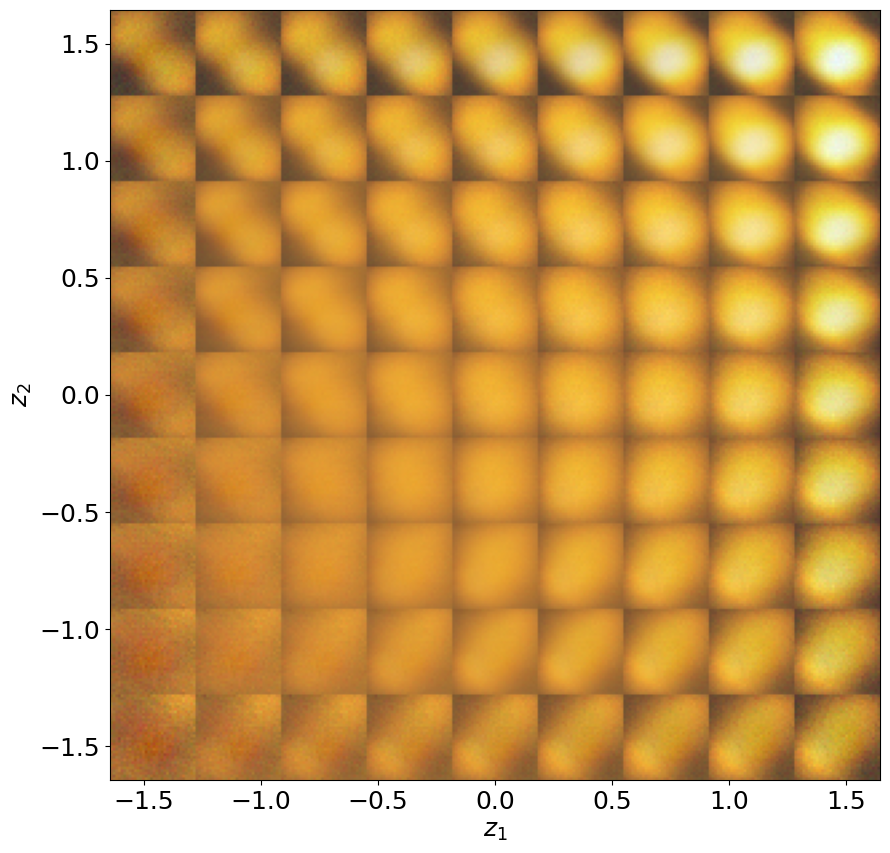

array([[[0.66635798, 0.39590169, 0.21309241],
        [0.63444156, 0.45757884, 0.21839824],
        [0.67777534, 0.44541852, 0.18827121],
        ...,
        [0.33297701, 0.28509029, 0.21525137],
        [0.35555835, 0.26679539, 0.17154989],
        [0.37302504, 0.28049904, 0.22442379]],

       [[0.62184389, 0.42515166, 0.20565634],
        [0.60079956, 0.36029858, 0.23030895],
        [0.67845367, 0.46640226, 0.18276445],
        ...,
        [0.36486656, 0.27092556, 0.19723828],
        [0.3639264 , 0.25146241, 0.17209319],
        [0.37160379, 0.27514936, 0.20641397]],

       [[0.63077325, 0.41542958, 0.21405861],
        [0.64278295, 0.48540238, 0.23016104],
        [0.66181501, 0.43849372, 0.22467028],
        ...,
        [0.38174691, 0.2406938 , 0.20080042],
        [0.3436173 , 0.2804139 , 0.18617726],
        [0.33604529, 0.29782632, 0.17245655]],

       ...,

       [[0.61518701, 0.40345878, 0.19926918],
        [0.69019716, 0.45282809, 0.21196834],
        [0.73993097, 0

In [9]:
# Plot the manifold
vae.manifold2d(cmap="jet")

In [10]:
z_mean, z_sd = vae.encode(train_data)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]

[0.61548835 0.38451165]
[0.5585356 0.4414644]
(2786,)
# digits: 2; # samples: 2786; # features 2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


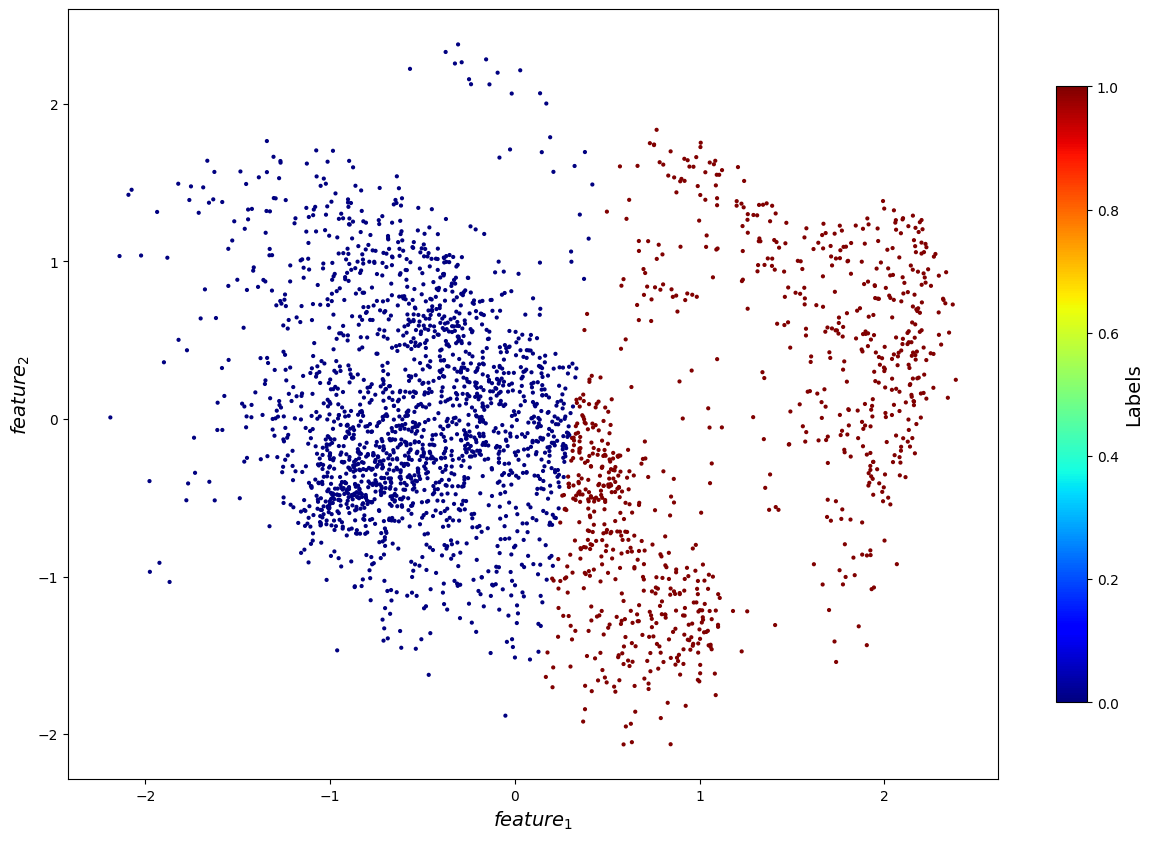

In [11]:
# load input
z, z_sd = vae.encode(train_data)

pca = PCA()
pca.fit(z)

print(pca.explained_variance_ratio_)
print(pca.singular_values_/sum(pca.singular_values_))

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(z)

# K-means clustering
n_cluster = 2
kmeans = KMeans(init="k-means++", n_clusters=2)
model = kmeans.fit(z)
train_labels = model.predict(z)

t = np.array(train_labels) # tensor to array
print(t.shape)

(n_samples, n_features), n_digits = z.shape, np.unique(t).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

fig, ax = plt.subplots(1, figsize =(15, 10))
im = ax.scatter(reduced_data[:,0], reduced_data[:,1], c=train_labels, s=4, cmap='jet')
ax.set_xlabel("$feature_1$", fontsize=14)
ax.set_ylabel("$feature_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

In [12]:
print(len(train_labels))
print(len(data_path))

2786
2786


In [13]:
import pandas as pd
Z = np.hstack((z, z_sd))

# Save to dataframe
df = pd.DataFrame({'image_path': data_path, 'Z': list(Z), 'label': list(train_labels)})

In [14]:
df.to_csv('vae_label.csv', index=False)

In [15]:
# Ititialize model
in_dim = (32, 32, 3)

#vae = aoi.models.VAE(in_dim)
rvae = aoi.models.rVAE(in_dim)

# Train
rvae.fit(X_train=train_data, X_test=train_data, training_cycles=40, batch_size=32)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: 1/40, Training loss: 132.0642, Test loss: 59.0384
Epoch: 2/40, Training loss: 58.0428, Test loss: 57.1321
Epoch: 3/40, Training loss: 56.1926, Test loss: 55.1801
Epoch: 4/40, Training loss: 54.2800, Test loss: 52.9665
Epoch: 5/40, Training loss: 51.5985, Test loss: 50.0393
Epoch: 6/40, Training loss: 48.7914, Test loss: 47.3665
Epoch: 7/40, Training loss: 45.7316, Test loss: 44.1594
Epoch: 8/40, Training loss: 42.8142, Test loss: 41.1618
Epoch: 9/40, Training loss: 40.2657, Test loss: 38.9454
Epoch: 10/40, Training loss: 38.4027, Test loss: 37.6365
Epoch: 11/40, Training loss: 37.0113, Test loss: 36.3557
Epoch: 12/40, Training loss: 35.7465, Test loss: 34.9897
Epoch: 13/40, Training loss: 34.5053, Test loss: 34.3090
Epoch: 14/40, Training loss: 33.6146, Test loss: 33.0564
Epoch: 15/40, Training loss: 32.7306, Test loss: 32.2310
Epoch: 16/40, Training loss: 31.9204, Test loss: 31.4873
Epoch: 17/40, Training loss: 31.3366, Test loss: 31.2912
Epoch: 18/40, Training loss: 30.5582, T

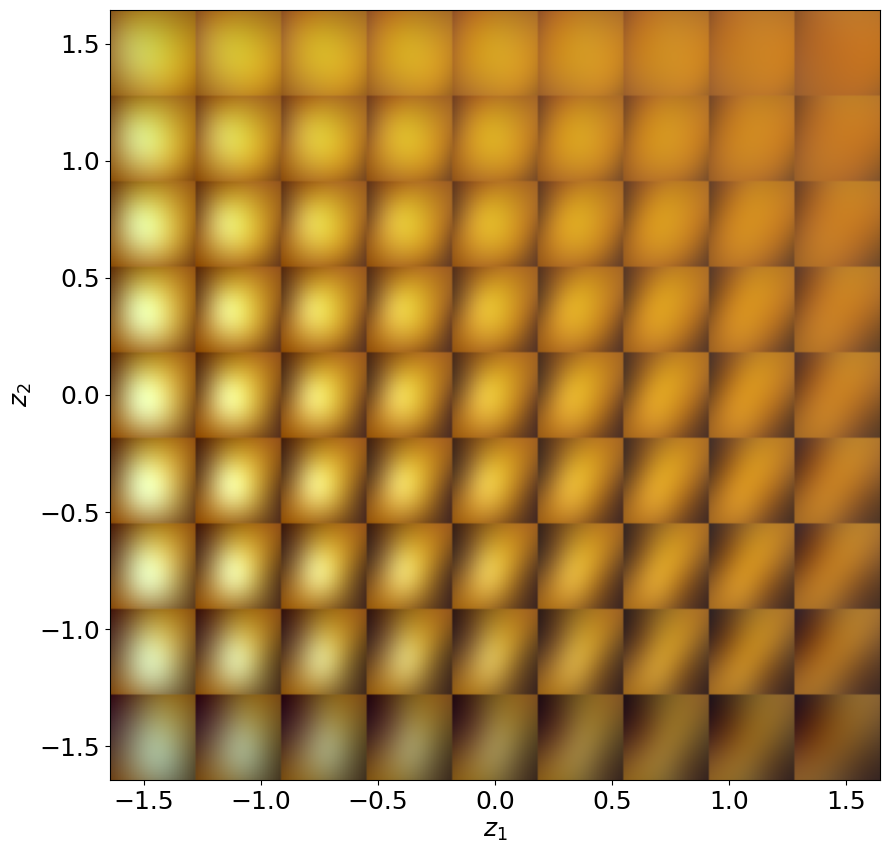

array([[[0.42210866, 0.25855885, 0.09368333],
        [0.43891667, 0.27959649, 0.11093902],
        [0.45503436, 0.30121847, 0.12952986],
        ...,
        [0.23853198, 0.16119145, 0.13462953],
        [0.23022923, 0.15605755, 0.13380071],
        [0.22256803, 0.15164374, 0.13335899]],

       [[0.41830172, 0.26168779, 0.10632072],
        [0.43613038, 0.28397793, 0.12455797],
        [0.45336293, 0.30698297, 0.14421845],
        ...,
        [0.24574203, 0.16563455, 0.13320725],
        [0.23729272, 0.16048482, 0.13268985],
        [0.22949269, 0.15605386, 0.13255707]],

       [[0.41376848, 0.26400027, 0.11832025],
        [0.43254641, 0.28746488, 0.13745968],
        [0.45082809, 0.3117789 , 0.158107  ],
        ...,
        [0.25356319, 0.17074435, 0.1322317 ],
        [0.24494   , 0.16554584, 0.13200923],
        [0.23697229, 0.16106127, 0.13216536]],

       ...,

       [[0.55494335, 0.37337842, 0.13405204],
        [0.5751904 , 0.39725944, 0.13954975],
        [0.59399463, 0

In [16]:
# Plot the manifold
rvae.manifold2d(cmap="jet")

[0.48996615 0.2286509  0.11466458 0.0988782  0.06784008]
[0.3346473  0.22860764 0.16188958 0.15033308 0.1245224 ]
(2786,)
# digits: 2; # samples: 2786; # features 5


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


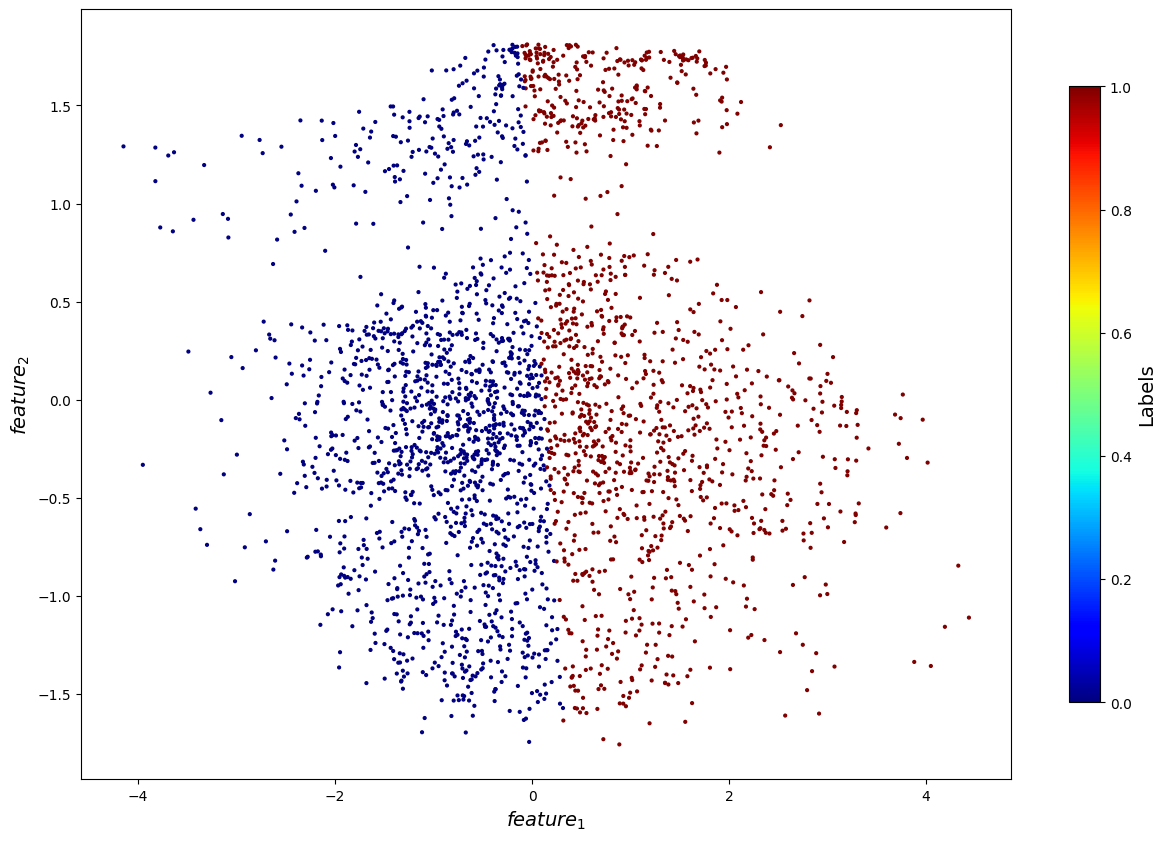

In [17]:
# load input
z, z_sd = rvae.encode(train_data)

pca = PCA()
pca.fit(z)

print(pca.explained_variance_ratio_)
print(pca.singular_values_/sum(pca.singular_values_))

import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(z)

# K-means clustering
n_cluster = 2
kmeans = KMeans(init="k-means++", n_clusters=2)
model = kmeans.fit(z)
train_labels = model.predict(z)

t = np.array(train_labels) # tensor to array
print(t.shape)

(n_samples, n_features), n_digits = z.shape, np.unique(t).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

fig, ax = plt.subplots(1, figsize =(15, 10))
im = ax.scatter(reduced_data[:,0], reduced_data[:,1], c=train_labels, s=4, cmap='jet')
ax.set_xlabel("$feature_1$", fontsize=14)
ax.set_ylabel("$feature_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Labels", fontsize=14)
cbar.ax.tick_params(labelsize=10)

(2786, 5)
(2786, 5)


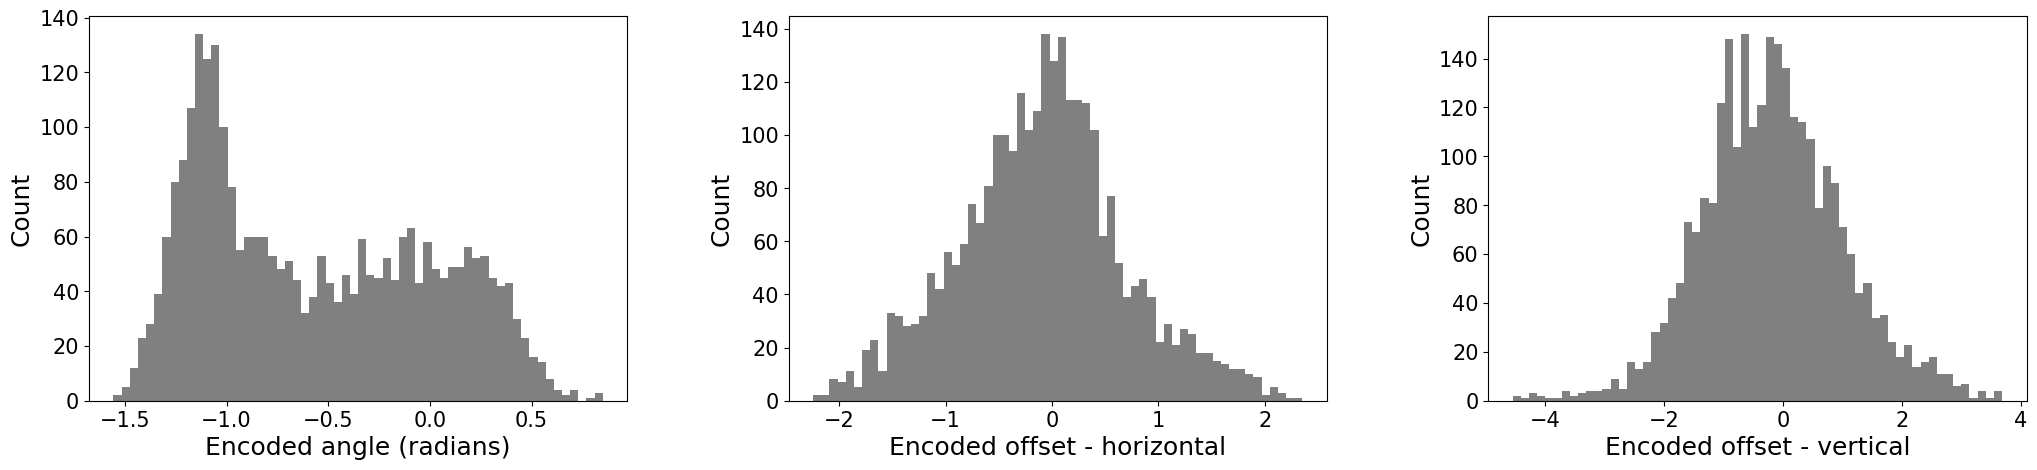

In [18]:
z_mean, z_sd = rvae.encode(train_data)
z1, z2, z3 = z_mean[:,0], z_mean[:, 1:3], z_mean[:, 3:]
print(z_mean.shape)
print(z_sd.shape)

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='gray')
ax[1].hist(z2[:, 0], bins=60, color='gray')
ax[2].hist(z2[:, 1], bins=60, color='gray')
ax[0].set_xlabel("Encoded angle (radians)", fontsize=18)
ax[1].set_xlabel("Encoded offset - horizontal", fontsize=18)
ax[2].set_xlabel("Encoded offset - vertical", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)